In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk

In [3]:
df = pd.read_csv("Reviews.csv")

In [4]:
df = df.head(10000) # cut down the dataset to first 10000, computer can't handle the full dataset

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print(df.shape)

(10000, 10)


In [7]:
counts = df["Score"].value_counts().sort_index()
counts

Score
1     932
2     590
3     862
4    1433
5    6183
Name: count, dtype: int64

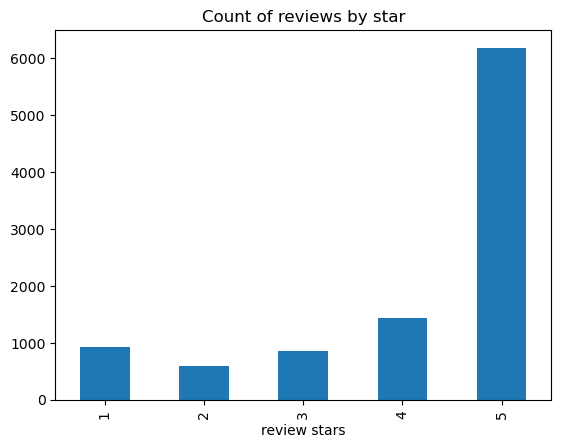

In [8]:
ax = counts.plot(kind = "bar",  title = "Count of reviews by star")

ax.set_xlabel("review stars")

plt.show()

#### Sentiment modelling

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [10]:
sia = SentimentIntensityAnalyzer()

Preprocess data : 
- Tokenization, converting text to lower case
- Removing punctuation and stop words
- Discarding words with length < threshold or word frequency < threshold
- Possibly lemmatization: Consider the lemmas instead of inflected forms.d- forms.

In [11]:
import spacy

nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

In [12]:
def preprocess(
    doc,
    min_token_len=2,
    irrelevant_pos=["ADV", "PRON", "CCONJ", "PUNCT", "PART", "DET", "ADP", "SPACE"],
):
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text
    and return a preprocessed string.

    Parameters
    -------------
    doc : (spaCy doc object)
        the spacy doc object of the text
    min_token_len : (int)
        min_token_length required
    irrelevant_pos : (list)
        a list of irrelevant pos tags

    Returns
    -------------
    (str) the preprocessed text
    """

    clean_text = []

    for token in doc:
        if (
            token.is_stop == False  # Check if it's not a stopword
            and len(token) > min_token_len  # Check if the word meets minimum threshold
            and token.pos_ not in irrelevant_pos
        ):  # Check if the POS is in the acceptable POS tags
            lemma = token.lemma_  # Take the lemma of the word
            clean_text.append(lemma.lower())
    return " ".join(clean_text)

In [13]:
df["text_pp"] = [preprocess(text) for text in nlp.pipe(df["Text"])]

In [14]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_pp
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy vitality can dog food product find good qu...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salted peanuts pean...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection century light pillowy citrus gelati...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


In [15]:
results = {}

for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row["text_pp"]
    myid = row["Id"]
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
df2 = pd.DataFrame(results).T

df2 = df2.reset_index().rename(columns = {"index" : "Id"})
df2 = df2.merge(df, how = "left")

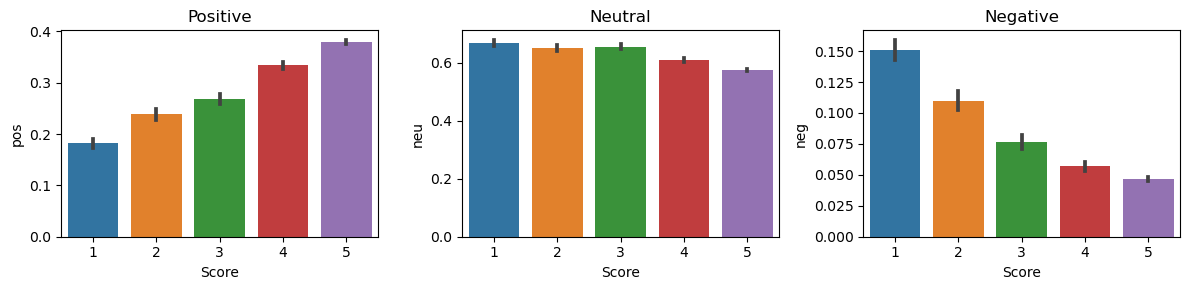

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3))

sns.barplot(data = df2 , x = "Score", y = "pos", ax = axs[0])
sns.barplot(data = df2 , x = "Score", y = "neu", ax = axs[1])
sns.barplot(data = df2 , x = "Score", y = "neg", ax = axs[2])

axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.tight_layout()
plt.show()

Positivity is higher as the scores are higher in the first visualization. Neutral is somewhat flat across all review. Lower score has a higher negativity.

Popular words include flavor, like, taste and good, also indicating that most of the data set include positive sentiments.

In [21]:
df2.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_pp
0,1,0.000,0.615,0.385,0.8402,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy vitality can dog food product find good qu...
1,2,0.135,0.750,0.115,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salted peanuts pean...
2,3,0.140,0.572,0.288,0.8176,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection century light pillowy citrus gelati...
3,4,0.000,0.847,0.153,0.4404,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...
4,5,0.000,0.369,0.631,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


In [22]:
df2["Sentiment_Label"] = df["Text"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [23]:
df2.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_pp,Sentiment_Label
0,1,0.000,0.615,0.385,0.8402,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy vitality can dog food product find good qu...,pos
1,2,0.135,0.750,0.115,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salted peanuts pean...,neg
2,3,0.140,0.572,0.288,0.8176,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection century light pillowy citrus gelati...,pos
3,4,0.000,0.847,0.153,0.4404,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,neg
4,5,0.000,0.369,0.631,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,pos


In [24]:
df2["Sentiment_Label"].value_counts()

Sentiment_Label
pos    8786
neg    1214
Name: count, dtype: int64

In [25]:
df2.groupby("Sentiment_Label")["Score"].mean()

Sentiment_Label
neg    2.576606
pos    4.349761
Name: Score, dtype: float64

In [26]:
from sklearn.model_selection import train_test_split

X = df2["text_pp"]
y = df2["Sentiment_Label"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 123)


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)


In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Initialize Logistic Regression classifier
lr = LogisticRegression()

# Perform cross-validation
cv_scores = cross_val_score(lr, X_train_counts, y_train, cv=5, scoring='accuracy')

In [29]:
cv_scores.mean()

0.8985714285714286

In [30]:
# Train the classifier on the entire training set
lr.fit(X_train_counts, y_train)

# Predict sentiments on the test data
y_pred = lr.predict(X_test_counts)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.893
              precision    recall  f1-score   support

         neg       0.57      0.40      0.47       355
         pos       0.92      0.96      0.94      2645

    accuracy                           0.89      3000
   macro avg       0.75      0.68      0.71      3000
weighted avg       0.88      0.89      0.88      3000

